# Als Parameter Tuning

## importing Libraries

In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append('../')
from src.utils import loading, Spark
from src.evaluation import Evaluator, Cross_validate_als
from src.model_based import Als
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

spark = Spark()

Spark UI address http://127.0.0.1:4040


## Loading Splitted Data

In [2]:
splits = loading(spark, '../data/interim')
print(list(splits.keys()))

['train_0.5_0.5', 'train_0.25_0.75', 'test_0.5_0.5', 'test_0.25_0.75', 'train_0.75_0.25', 'test_0.75_0.25']


## Declaring Grid and Evaluators

In [3]:
parameters = {
    "regParam": [0.01, 0.05, 0.1, 0.15],
    "rank": [10, 50, 100, 150, 200]
}
evaluators = {'rmse': Evaluator(metrics = 'rmse'), 
              'accuracy': Evaluator(metrics = 'accuracy'), 
              'coverage_user': Evaluator(metrics = 'converage_k', 
                                       ratingCol='rating', 
                                       predCol='prediction', 
                                       idCol='userId', 
                                       k=10),
              'coverage_item': Evaluator(metrics = 'converage_k', 
                                       ratingCol='rating', 
                                       predCol='prediction', 
                                       idCol='movieId', 
                                       k=100)}

## Running Grid Search

In [4]:
%%time
result = []
for i in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    train, test = splits['train_' + i], splits['test_' + i]
    res = Cross_validate_als(training = train,
                            test= test,
                            valid_ratio = .1,
                            regParam = parameters['regParam'],
                            rank = parameters['rank'],
                            seed = 0,
                            evaluators = list(evaluators.values()))
    result.append(res)

100%|██████████| 20/20 [08:57<00:00, 26.89s/it]

CPU times: user 1.74 s, sys: 680 ms, total: 2.42 s
Wall time: 35min 12s


## Saving Results

In [18]:
for i in result:
    i.columns = ['rmse', 'accuracy', 'coverage_user', 'coverage_item']

In [19]:
als_parameter_tuning = pd.DataFrame(columns = ['rmse', 'accuracy', 'coverage_user', 'coverage_item', 'split'])
for i, j in zip(result, ['0.75_0.25', '0.5_0.5', '0.25_0.75']):
    i['split'] = j
    als_parameter_tuning = als_parameter_tuning.append(i)
als_parameter_tuning = als_parameter_tuning.dropna()
als_parameter_tuning.index.name = '(regParam, rank)'
als_parameter_tuning.to_csv('../data/processed/tuning_result/als_parameter_tuning.csv', header=True, index=True)

# Results analysis

In [2]:
tuning_res = pd.read_csv(path.join('../data', 'processed', 'tuning_result','als_parameter_tuning.csv'))
tuning_res['regParam'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[0].astype(float)
tuning_res['rank'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[1].astype(int)
tuning_res = tuning_res.set_index('(regParam, rank)')

## Plot of metrics change w.r.t different rank 

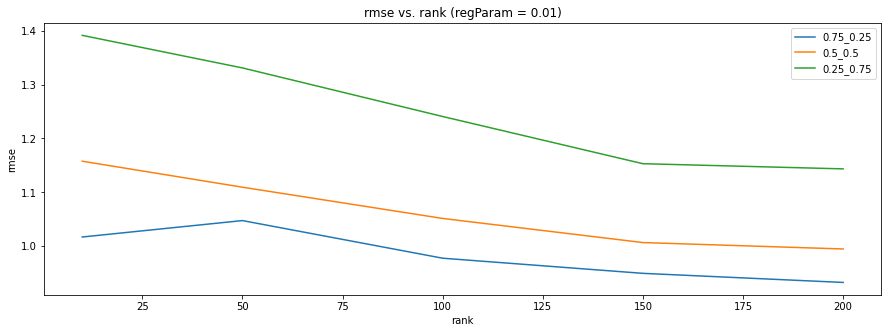

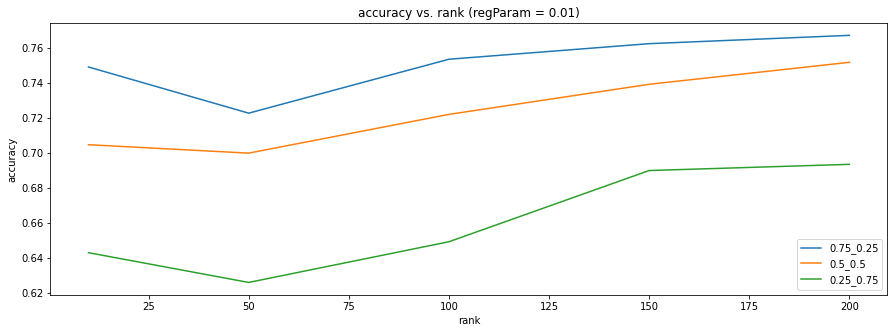

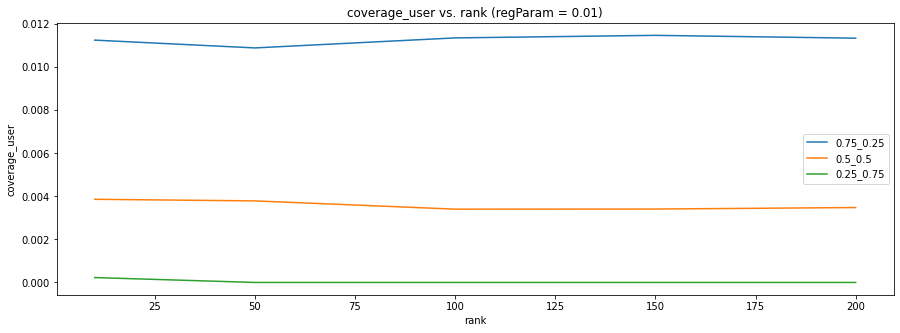

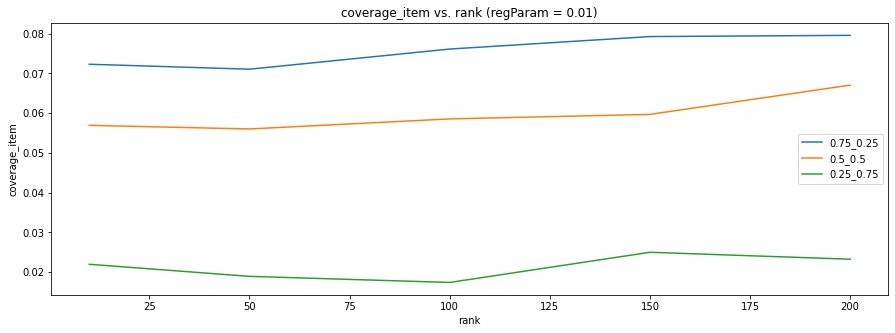

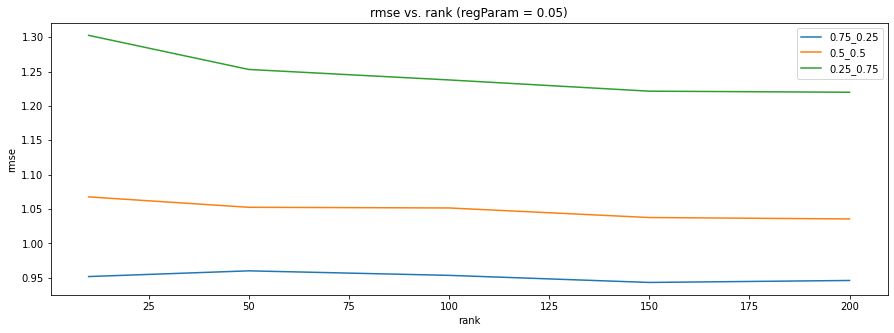

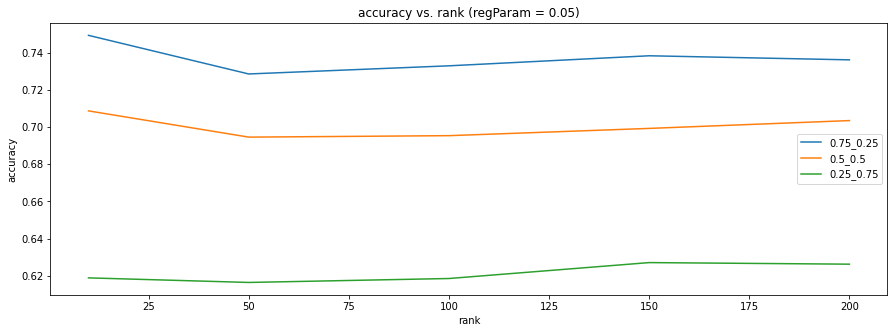

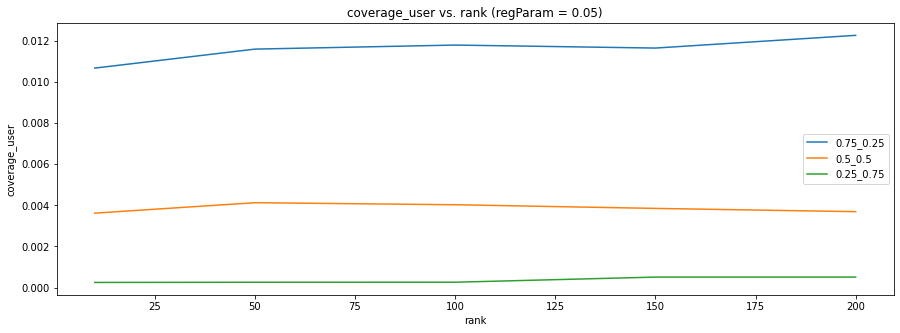

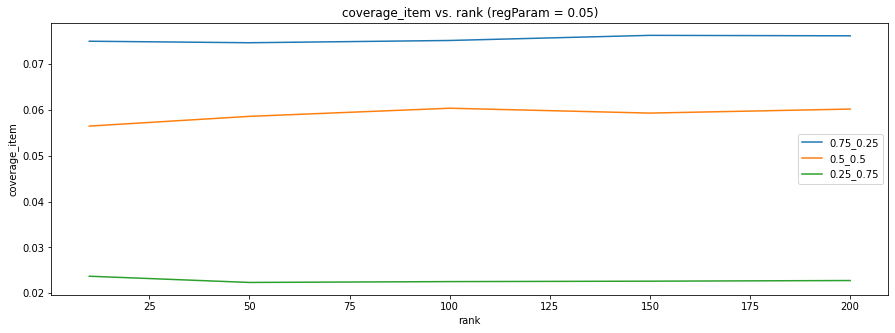

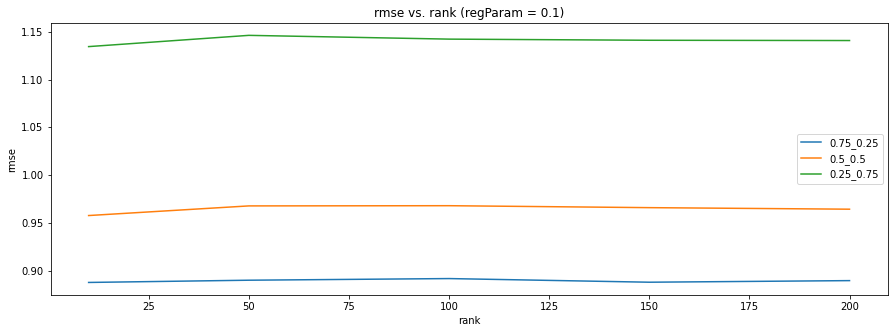

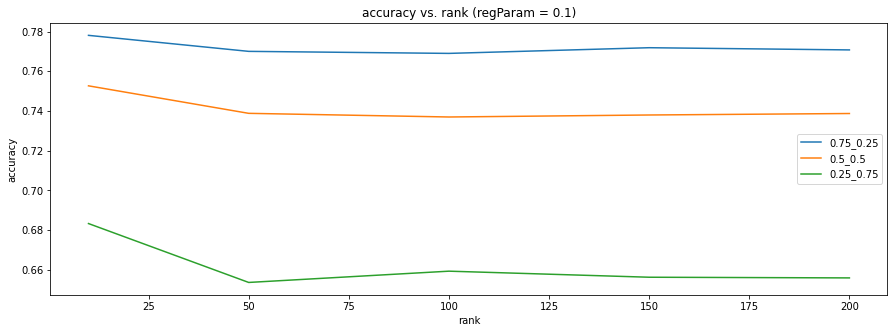

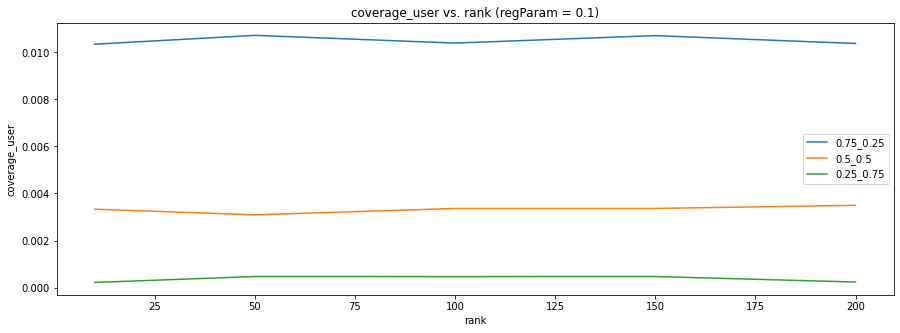

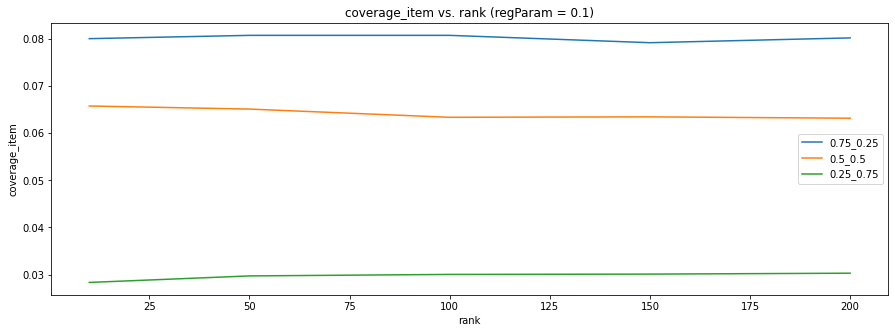

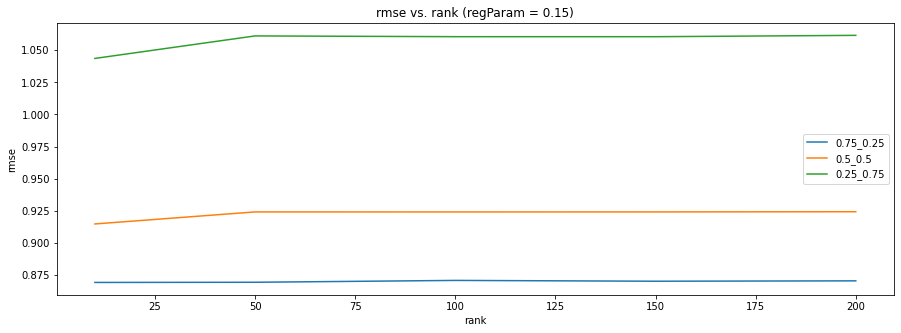

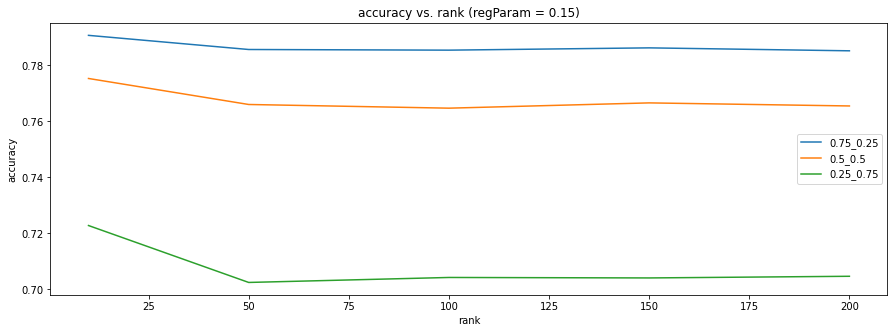

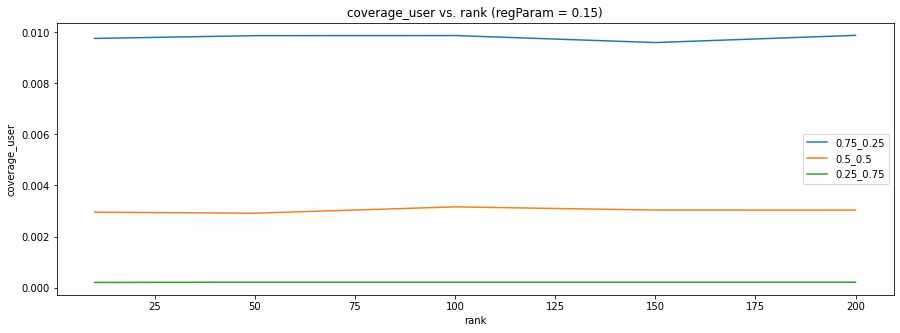

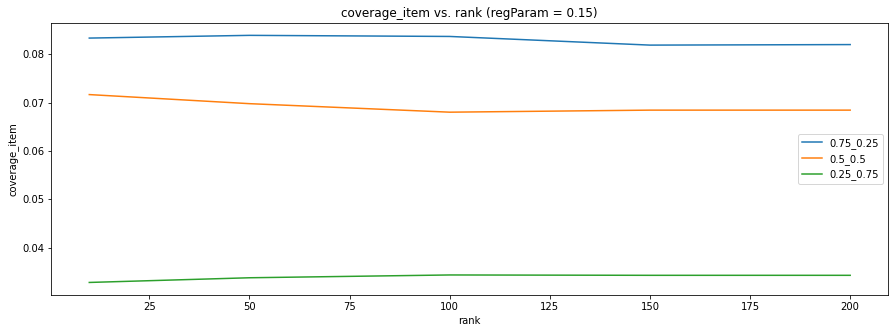

In [3]:
for regParam in tuning_res.regParam.unique():
    subsets = tuning_res[tuning_res.regParam == regParam]
    for metric in ['rmse', 'accuracy', 'coverage_user', 'coverage_item']:
        for split in subsets['split'].unique():
            subset = subsets[subsets['split'] == split]
            plt.plot(subset['rank'], subset[metric], label = split)
            plt.legend()
        plt.title(f'{metric} vs. rank (regParam = {regParam})')
        plt.xlabel('rank')
        plt.ylabel(metric)
        plt.show()

## Plot of metrics change w.r.t different regParam

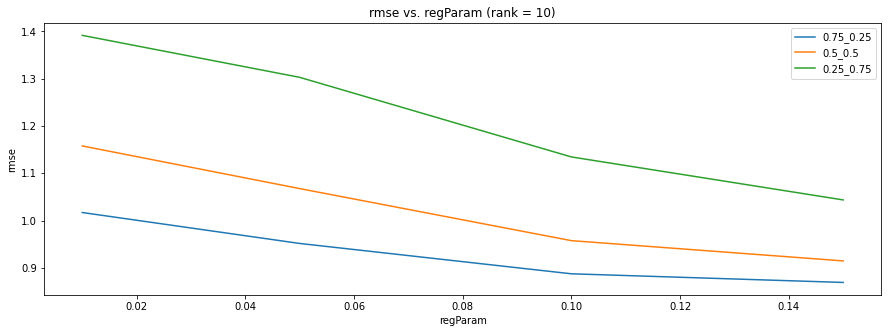

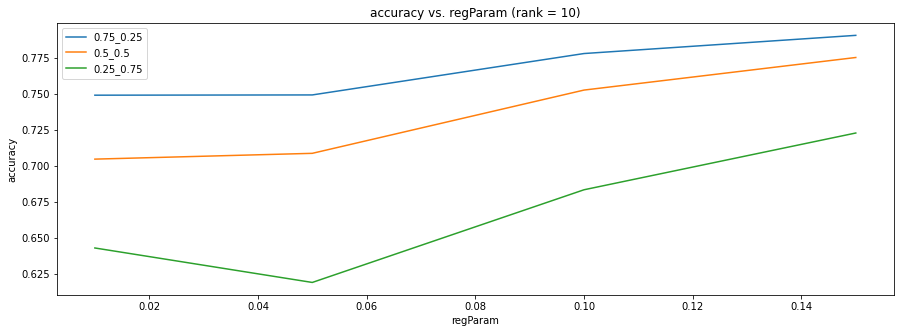

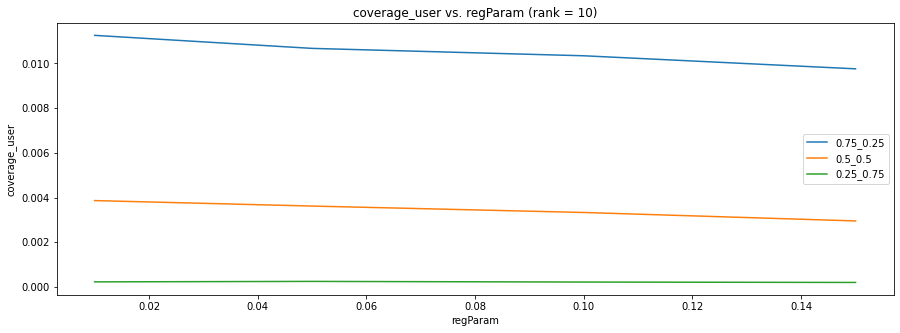

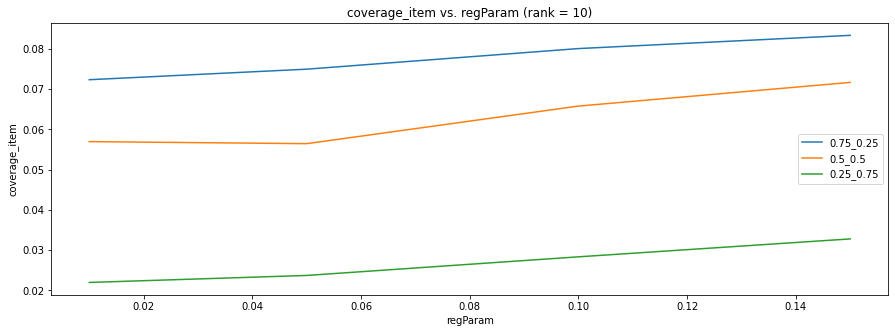

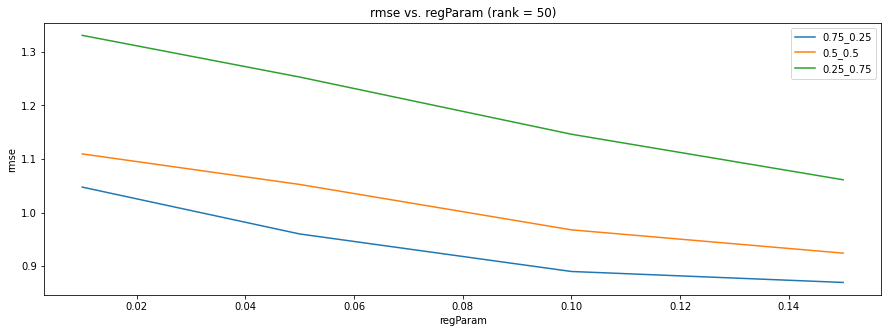

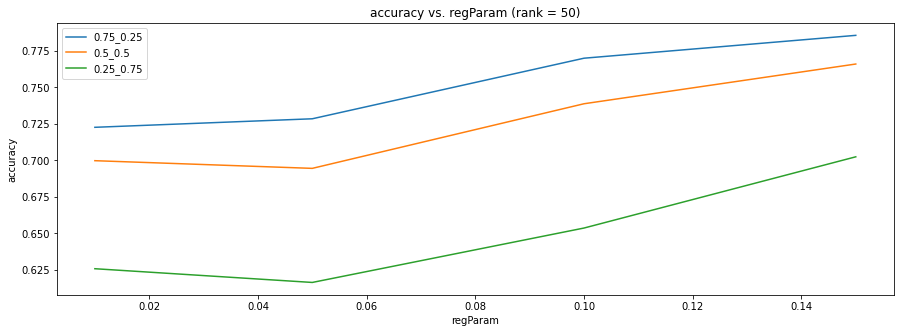

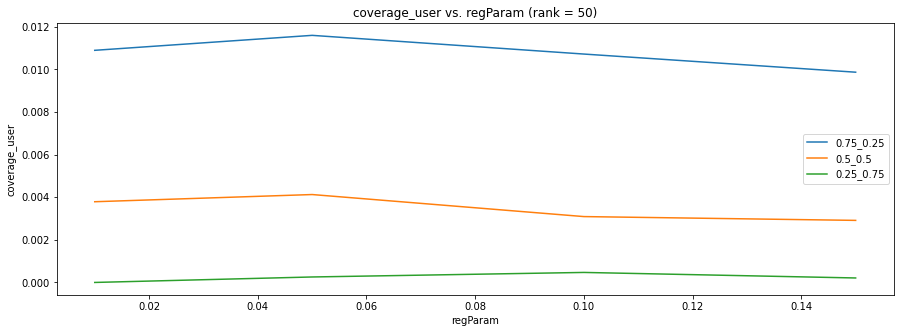

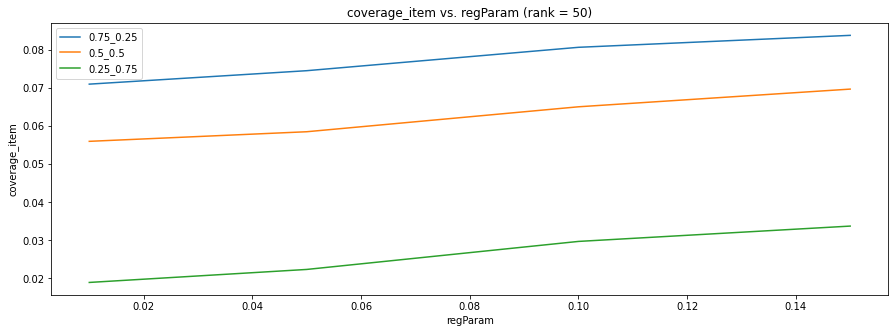

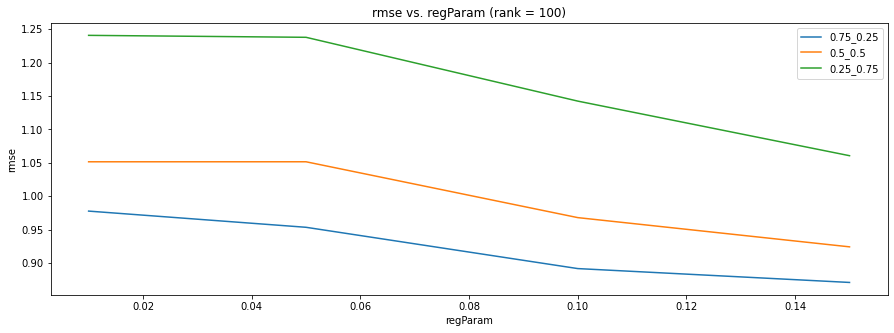

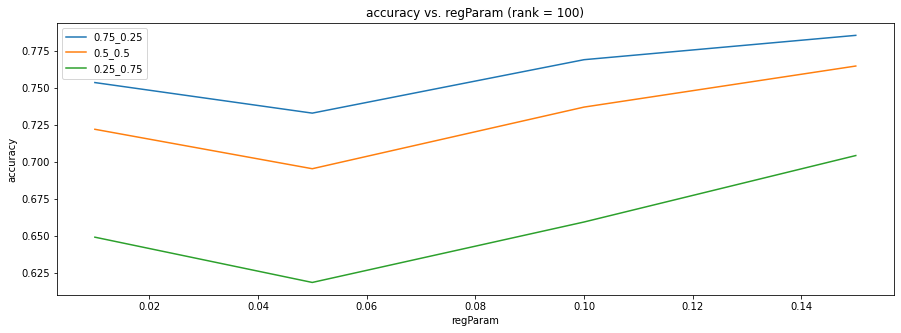

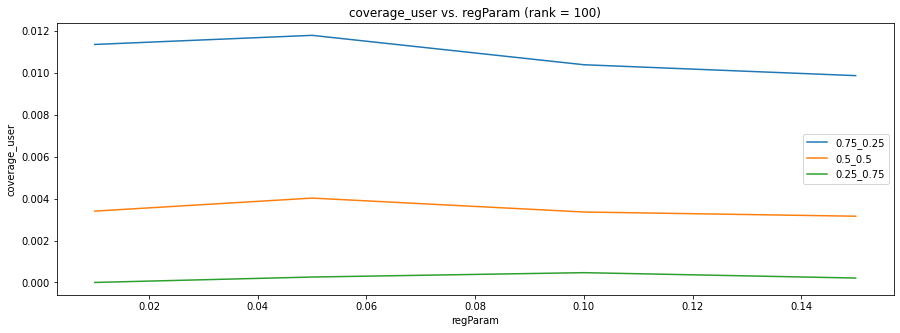

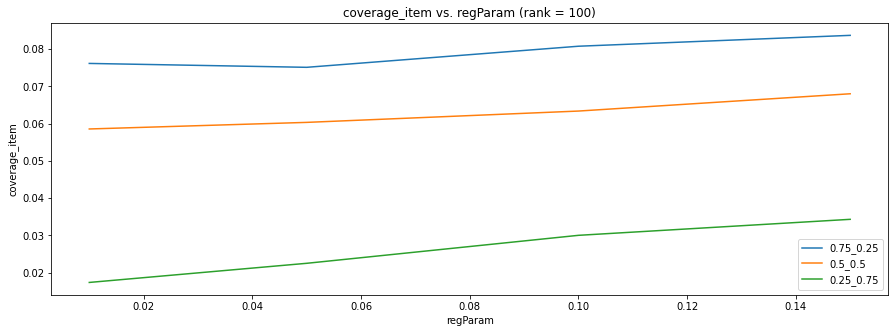

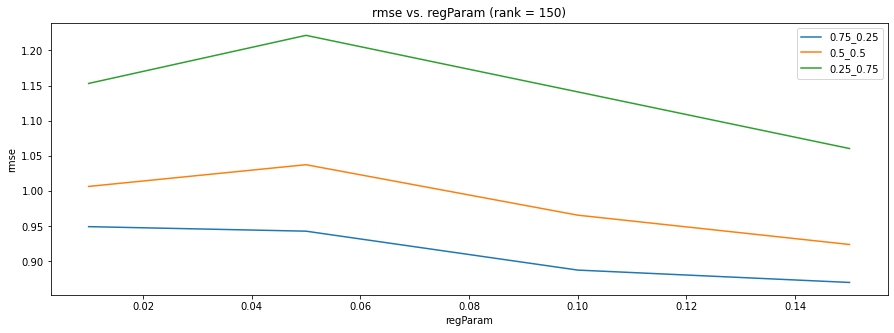

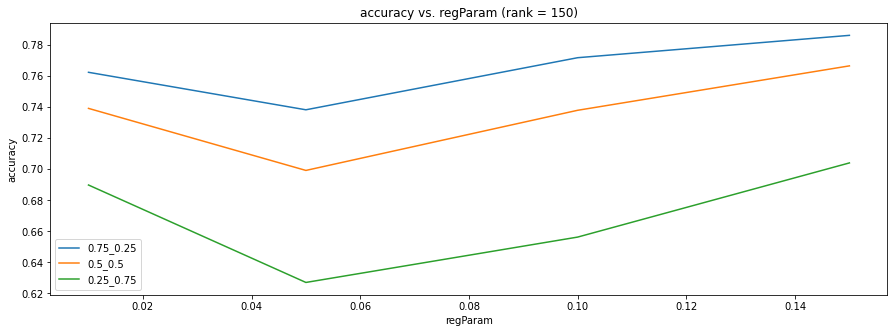

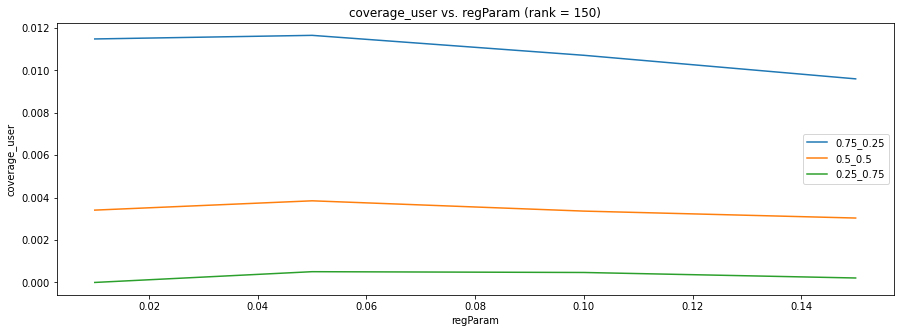

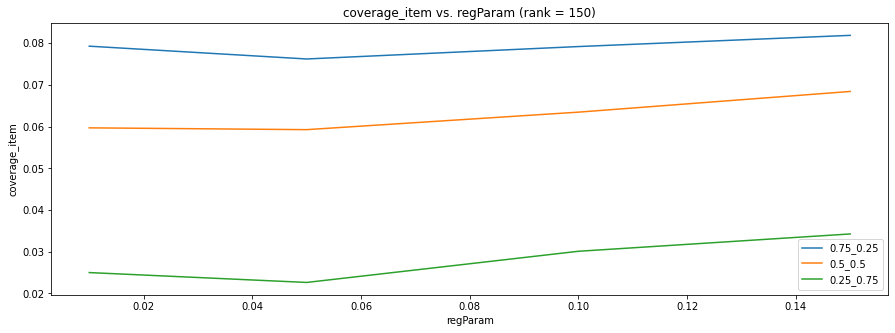

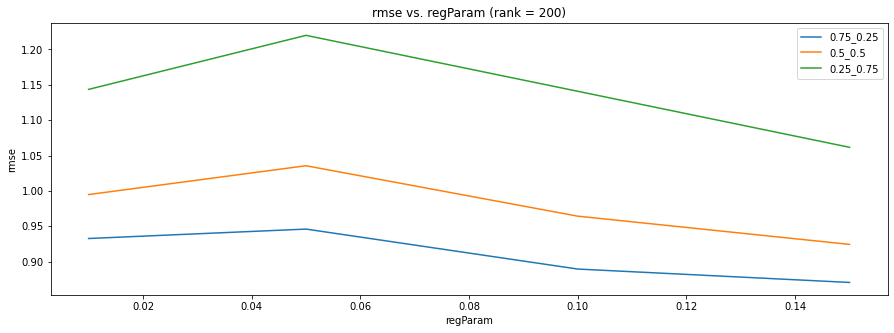

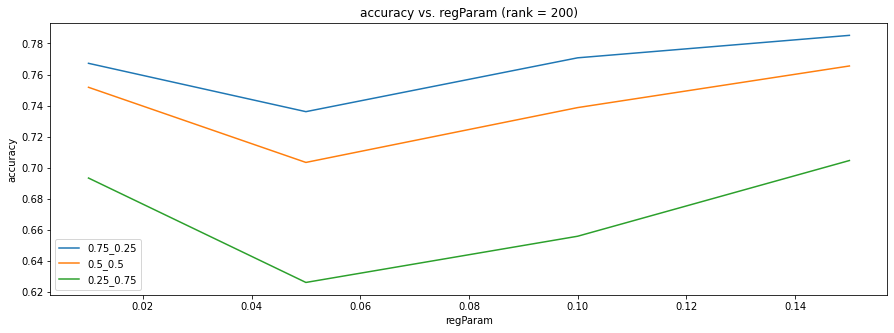

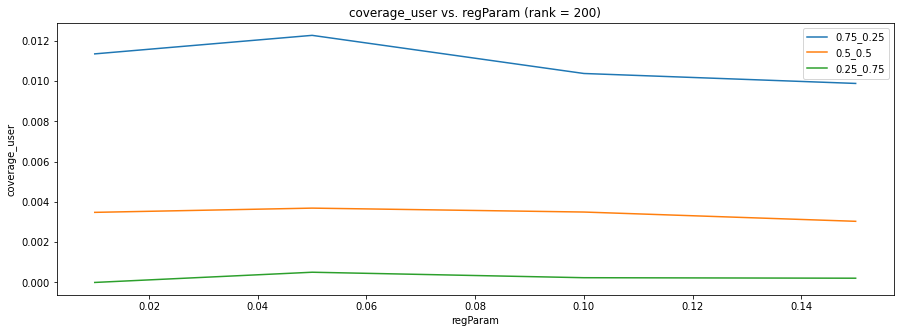

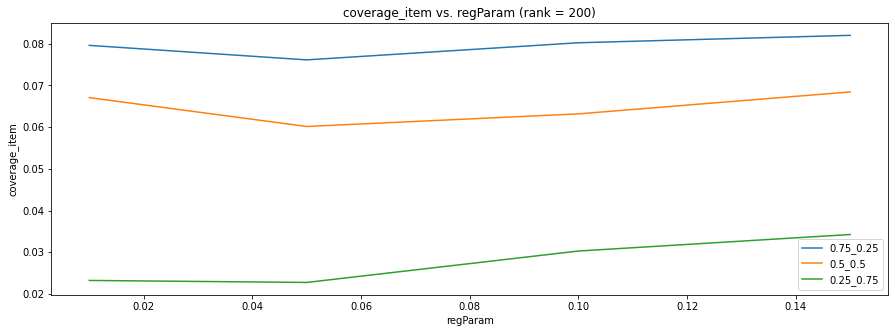

In [4]:
for rank in tuning_res['rank'].unique():
    subsets = tuning_res[tuning_res['rank'] == rank]
    for metric in ['rmse', 'accuracy', 'coverage_user', 'coverage_item']:
        for split in subsets['split'].unique():
            subset = subsets[subsets['split'] == split]
            plt.plot(subset['regParam'], subset[metric], label = split)
            plt.legend()
        plt.title(f'{metric} vs. regParam (rank = {rank})')
        plt.xlabel('regParam')
        plt.ylabel(metric)
        plt.show()